In [1]:
#open cv 파이썬 버전
#!pip install opencv-python

In [1]:
#필요한 모듈을 import 합니다.
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


#데이터 불러오기 위해 필요한 라이브러리
import os
import cv2    #open cv 파이썬 버전
from sklearn.preprocessing import LabelEncoder    #이미지의 이름을 수치화 하여 라벨링 하기 위함
from glob import glob    #디렉토리를 리스트로 불러옴


#모델에 필요한 라이브러리
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam, Nadam, Adadelta
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import to_categorical
#import h5py    #크고 복잡한 대용량 데이터를 저장하기 위한 파일 형식
                #         - 모델을 저장하기 위함


    
#L2 정규화(Ridge):모형의 복잡성은 가중치의 제곱합으로 표현
from tensorflow.keras.regularizers import l2

In [2]:
# 데이터 로드 함수
def img_load(local):
    img_paths = glob(local)
    data = []
    label = []
    
    for path in img_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (125, 125))
        
        label.append(path.split('\\')[5])        
        data.append(img)
    
    le = LabelEncoder()
    label = le.fit_transform(label)
    
    #더 높은 정확도를 위해 train 이미지를 섞음
    np.random.seed(42)
    index = np.arange(len(data))
    np.random.shuffle(index)
    
    data = np.array(data)
    data = data[index[:]]
    label = label[index[:]]
    
    return data, label

In [3]:
#train 데이터 로드
x_train, y_train = img_load('D:\\Python\\MachineLearning_FinalProject\\data\\train\\*\\*')

In [4]:
#test 데이터 로드
x_test, y_test = img_load('D:\\Python\\MachineLearning_FinalProject\\data\\test\\*\\*')

In [5]:
x_train

array([[[[246, 245, 241],
         [246, 245, 241],
         [247, 246, 242],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[247, 246, 242],
         [247, 246, 242],
         [247, 246, 242],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[248, 247, 243],
         [249, 248, 244],
         [249, 248, 244],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
        

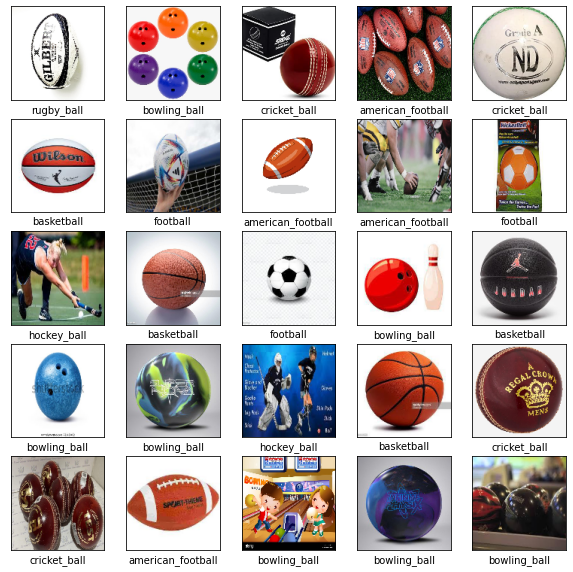

In [7]:
label_names = ['american_football', 'basketball', 'bowling_ball', 'cricket_ball', 'football', 'hockey_ball', 'rugby_ball']
plt.figure(figsize = (10, 10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i])
    plt.xlabel(label_names[y_train[i]])
plt.show()

In [8]:
# 공의 종류 (레이블) 갯수
y_train[10]

5

In [9]:
# x_train의 x차원 확인
x_train.shape

(3372, 125, 125, 3)

In [10]:
# y_train의 y차원 확인
y_train.shape

(3372,)

#  

In [11]:
x_test

array([[[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
        

In [12]:
y_test[10]

4

In [13]:
# x_test의 x차원 확인
x_test.shape

(847, 125, 125, 3)

In [14]:
# y_test의 y차원 확인
y_test.shape

(847,)

# 데이터 전처리

In [15]:
#더 높은 정확도를 위해 train 이미지가 제대로 섞었는지 확인
y_train

array([6, 2, 3, ..., 3, 2, 6], dtype=int64)

In [16]:
# nomalization : 정규화
x_train = x_train.astype(dtype='float32') / 255
x_train

array([[[[0.9647059 , 0.9607843 , 0.94509804],
         [0.9647059 , 0.9607843 , 0.94509804],
         [0.96862745, 0.9647059 , 0.9490196 ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[0.96862745, 0.9647059 , 0.9490196 ],
         [0.96862745, 0.9647059 , 0.9490196 ],
         [0.96862745, 0.9647059 , 0.9490196 ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[0.972549  , 0.96862745, 0.9529412 ],
         [0.9764706 , 0.972549  , 0.95686275],
         [0.9764706 , 0.972549  , 0.95686275],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        ...,

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]

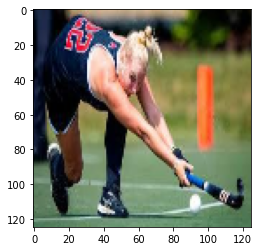

In [17]:
# 이미지 출력
plt.imshow(x_train[10])
plt.show()

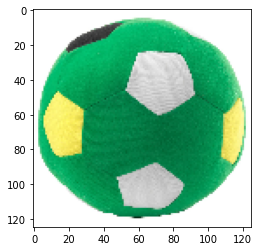

In [18]:
# 이미지 출력
plt.imshow(x_test[10])
plt.show()

# 모델

In [19]:
# 하이퍼 파라미터
image_size_h = 125
image_size_v = 125

batch_size = 128
epochs = 50

conv = 3
pool = 2

nb_class = 7

learning_rate = 1e-4

optimizer = Adam(learning_rate)

# 모델 쌓기
model = Sequential()

model.add(Conv2D(32, (conv, conv), input_shape=(image_size_h, image_size_v, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((pool, pool), padding='same'))

# 여기서 부터
model.add(Conv2D(64, (conv, conv), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((pool, pool), padding='same'))


##### 추가 #####
model.add(Conv2D(64, (conv, conv), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((pool, pool), padding='same'))

model.add(Conv2D(64, (conv, conv), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((pool, pool), padding='same'))

model.add(Conv2D(64, (conv, conv), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((pool, pool), padding='same'))

model.add(Conv2D(128, (conv, conv), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((pool, pool), padding='same'))
################


model.add(Conv2D(128, (conv, conv), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((pool, pool), padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, kernel_regularizer=l2(learning_rate)))
model.add(Activation('relu'))
# 여기까지 층 쌓기

model.add(Dense(nb_class))
model.add(Activation('softmax'))

#sparse_categorical_crossentropy은 분류할 클래스 3개 이상일 경우 사용
#레이블이 정수형 숫자일 경우
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

#모델을 파일 형식으로 저장하기 위한 코드
#model.save('./Model/Ball_image_processing.h5')

hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.20)
#model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.20)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 32)      896       
                                                                 
 activation (Activation)     (None, 125, 125, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 63, 63, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                    

In [20]:
train_score = model.evaluate(x_train, y_train, batch_size=batch_size, verbose=0)

# Loss : 몇, Accuracy : 몇 (*train set에서 적어도 Accuracy가 90퍼는 넘겨야 됨 / 안넘으면 test set을 돌릴 가치도 없는 모델) 
print("Loss : {:.4f}, Accuracy : {:.4f}".format(train_score[0], train_score[1]))

Loss : 1.0936, Accuracy : 0.6115


In [21]:
test_score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)

# Accuracy : 몇 (*test set에서 적어도 Accuracy가 50퍼는 넘겨야돼)
print("Accuracy : {:.4f}".format(test_score[1]))

Accuracy : 0.4982


In [22]:
#plt.plot(hist.history['loss'])
#plt.plot(hist.history['val_loss'])
#plt.xlabel('epochs')
#plt.ylabel('loss')

In [23]:
#plt.plot(hist.history['accuracy'])
#plt.plot(hist.history['val_accuracy'])
#plt.xlabel('epochs')
#plt.ylabel('accuracy')